In [190]:
import math
import numpy as np
import os

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set()
sns.set_style("ticks")
sns.set_context("paper")
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [202]:
three_d_points = np.array([
    [-0.08, -2.30333333, 1.19666667],  # Top right solar panel
    [-0.15666667, -0.84333333, 1.19666667],  # Top left solar panel
    [-0.08, -2.30333333, -0.78333333],  # Bottom right solar panel
    [-0.15666667, -0.84333333, -0.78333333],  # Bottom left solar panel
    [-0.24333333, 1.03, -0.65333333],  # Bottom left satellite
])

three_d_points_names = [
    'Top right solar panel',
    'Top left solar panel',
    'Bottom right solar panel',
    'Bottom left solar panel',
    'Bottom left satellite'
]


def get_rotated_point(roll, pitch, yaw, point=None):
    if point is None:
        point = [-0.08, -2.30333333, 1.19666667]

    r_roll = np.array([[1, 0, 0],
                       [0, math.cos(roll / 180 * math.pi), -math.sin(roll / 180 * math.pi)],
                       [0, math.sin(roll / 180 * math.pi), math.cos(roll / 180 * math.pi)]])

    r_pitch = np.array([[math.cos(pitch / 180 * math.pi), 0, math.sin(pitch / 180 * math.pi)],
                        [0, 1, 0],
                        [-math.sin(pitch / 180 * math.pi), 0, math.cos(pitch / 180 * math.pi)]])

    r_yaw = np.array([[math.cos(yaw / 180 * math.pi), -math.sin(yaw / 180 * math.pi), 0],
                      [math.sin(yaw / 180 * math.pi), math.cos(yaw / 180 * math.pi), 0],
                      [0, 0, 1]])

    rotation_matrix = r_yaw @ r_pitch @ r_roll

    rotated_3d_points = np.dot(rotation_matrix, point)

    return rotated_3d_points

In [192]:
folder = "../test_images/dynamic_unknowndeg_0to360_5degstep/"
suffixes = ['_linefit_eps2']
colors = ['red', 'green', 'blue']
nice_suffixes = [s.removeprefix("_").replace('_', ' ').capitalize() for s in suffixes]


In [193]:
df_true = pd.read_csv(folder + "real_scores.csv")
df_true = df_true.rename(columns={'correct_roll': 'true_roll', 'correct_pitch': 'true_pitch', 'correct_yaw':
    'true_yaw'})
df_true['img_number'] = df_true.index

In [194]:
df = pd.DataFrame()
for suffix in suffixes:
    df_guess = pd.DataFrame()
    df_local = pd.read_csv(folder + "fine_scores" + suffix + ".csv")
    # folder + "guesses" + suffix + ".csv" is empty if the file is not found
    if os.path.exists(folder + "guesses" + suffix + ".csv"):
        df_guess = pd.read_csv(folder + "guesses" + suffix + ".csv")
        df_guess = df_guess.rename(columns={'roll': 'guess_roll', 'pitch': 'guess_pitch', 'yaw': 'guess_yaw'})
    # df_local = df_local.merge(df_true, on='img_number')
    if not df_guess.empty:
        df_local = df_local.merge(df_guess, on='img_number')
    df_local['suffix'] = suffix
    df = pd.concat([df, df_local])

    df = pd.concat([df, df_true])
df = df_local.merge(df_true, on='img_number')
df = df.reset_index(drop=True)


In [195]:
df

,img_number,iterations,loss,roll,pitch,yaw,x_x,y_x,z_x,guess_roll,...,x_min,x_max,y_min,y_max,z_min,z_max,suffix,true_roll,true_pitch,true_yaw
0,0,1288,3.861514e+02,2.705251,-97.550000,87.000000,0.114264,0.054625,-0.400000,0.000000,...,-0.400000,0.400000,-0.400000,0.400000,-0.400000,0.400000,_linefit_eps2,127.970000,-79.560000,-44.000000
1,1,756,1.050313e-11,-8.792401,-108.997907,89.582224,0.227290,0.165259,-0.258499,0.000000,...,-1.300000,1.300000,-1.300000,1.300000,-1.300000,1.300000,_linefit_eps2,123.295573,-78.244572,-44.152291
2,2,546,1.344628e-11,-12.841861,-109.662952,88.560803,0.227843,0.168713,-0.341809,-8.792401,...,0.027290,0.427290,-0.034741,0.365259,-0.458499,-0.058499,_linefit_eps2,119.068439,-76.935369,-44.763274
3,3,539,1.743068e-09,-18.080766,-109.990693,88.802768,0.228129,0.168919,-0.451883,-12.841861,...,0.027843,0.427843,-0.031287,0.368713,-0.541809,-0.141809,_linefit_eps2,115.161870,-75.638750,-45.707437
4,4,497,1.355868e+00,-26.080766,-111.363104,91.951286,0.226060,0.149381,-0.518505,-18.080766,...,0.028129,0.428129,-0.031081,0.368919,-0.651883,-0.251883,_linefit_eps2,111.491226,-74.359729,-46.901282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,68,476,6.316359e-02,-152.756194,-116.097010,-98.655675,0.121492,0.129389,-0.784776,-151.440150,...,0.121492,0.124306,0.117218,0.129389,-0.859160,-0.766941,_linefit_eps2,157.623186,-84.620406,-54.433702
69,69,364,2.722300e-01,-154.129103,-117.302377,-102.254955,0.110737,0.145633,-0.960581,-154.168823,...,0.110737,0.114098,0.136254,0.145633,-0.976554,-0.897401,_linefit_eps2,147.366750,-83.432329,-48.971823
70,70,273,8.634383e-02,-155.845001,-118.833171,-105.124379,0.099020,0.154535,-1.076342,-155.805755,...,0.099020,0.103465,0.154535,0.163655,-1.163456,-1.076342,_linefit_eps2,139.573127,-82.170727,-45.978678
71,71,1652,9.615106e+01,-158.620335,-119.947848,-107.522630,0.090212,0.173241,-1.276759,-157.738289,...,0.086847,0.090212,0.162019,0.173241,-1.276759,-1.167727,_linefit_eps2,133.288987,-80.872993,-44.502381


In [196]:
def plot_guess(guess_type):
    sns.lineplot(data=df, x='img_number', y='guess_' + guess_type, color='blue', ci=None)
    sns.lineplot(data=df, x='img_number', y=guess_type + '_min', color='red', ci=None)
    sns.lineplot(data=df, x='img_number', y=guess_type + '_max', color='green', ci=None)
    sns.scatterplot(data=df, x='img_number', y=guess_type, color='black')
    plt.legend(['Guess', 'Min', 'Max', 'Lowest loss estimate'])
    plt.title('SMA ' + guess_type + ' guesses')
    plt.xlabel('Image number')
    plt.ylabel(guess_type + ' (deg)')
    plt.show()


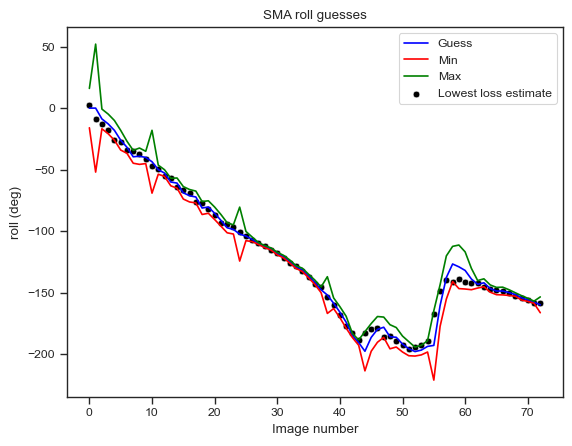

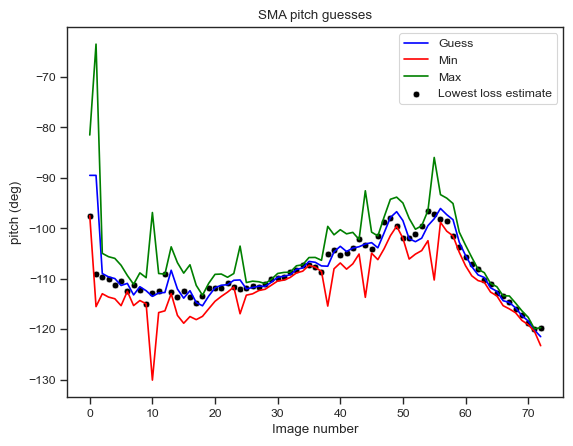

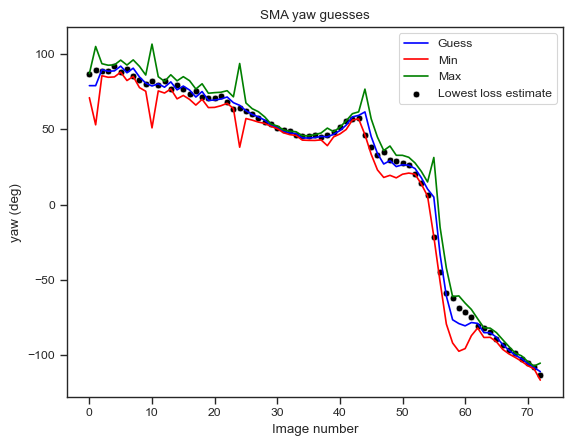

In [197]:
for guess_type in ['roll', 'pitch', 'yaw']:
    plot_guess(guess_type)

In [198]:
def plot_reg(guess_type):
    sns.regplot(data=df, x='true_' + guess_type, y='guess_' + guess_type, ci=None)
    plt.show()

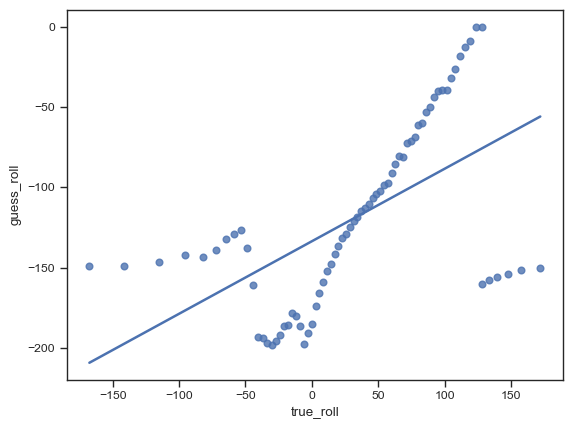

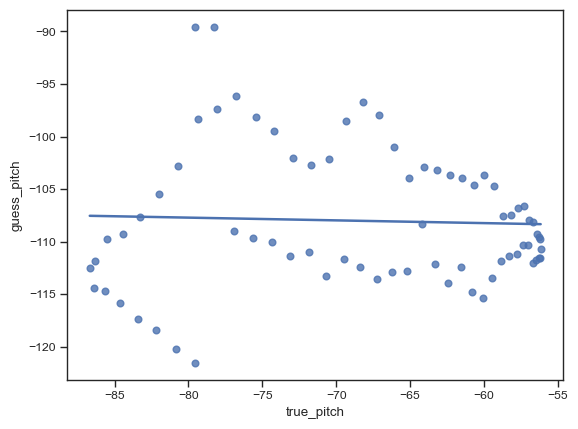

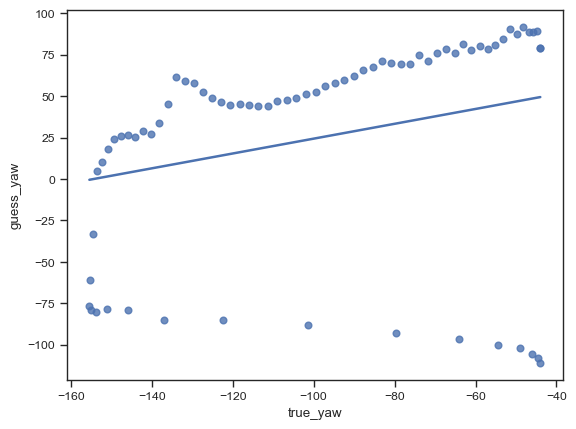

In [199]:
for guess_type in ['roll', 'pitch', 'yaw']:
    plot_reg(guess_type)

In [205]:
df_rotated_points = pd.DataFrame()
for i, point in enumerate(three_d_points):
    df_local = df.apply(
        lambda row: get_rotated_point(row['true_roll'], row['true_pitch'], row['true_yaw'], point),
        axis=1, result_type='expand')
    df_local = df_local.rename(columns={0: 'x', 1: 'y', 2: 'z'})
    df_local['img_number'] = df['img_number']
    df_local['suffix'] = df['suffix']
    df_local['3d_point'] = three_d_points_names[i]
    df_rotated_points = pd.concat([df_local, df_rotated_points])

In [206]:
df_rotated_points

,x,y,z,img_number,suffix,3d_point
0,-0.972931,0.774589,-0.019331,0,_linefit_eps2,Bottom left satellite
1,-0.905724,0.852359,0.010240,1,_linefit_eps2,Bottom left satellite
2,-0.831538,0.924142,0.038223,2,_linefit_eps2,Bottom left satellite
3,-0.750938,0.989393,0.064404,3,_linefit_eps2,Bottom left satellite
4,-0.664538,1.047615,0.088584,4,_linefit_eps2,Bottom left satellite
...,...,...,...,...,...,...
68,2.506175,-0.626336,-0.265601,68,_linefit_eps2,Top right solar panel
69,2.437663,-0.829527,-0.336806,69,_linefit_eps2,Top right solar panel
70,2.350676,-1.025953,-0.406813,70,_linefit_eps2,Top right solar panel
71,2.245876,-1.214118,-0.475091,71,_linefit_eps2,Top right solar panel


In [207]:
df_rotated_points.to_csv(folder + 'rotated_points.csv', index=False)